In [2]:
!uv pip install celluloid

Using Python 3.12.12 environment at: /usr
Resolved 12 packages in 351ms                                        
Prepared 1 package in 26ms                                               
Installed 1 package in 2ms                                  
 + celluloid==0.2.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from itertools import product
from tqdm.notebook import tqdm
#!pip install ipywidgets

from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import seaborn as sns
from IPython.display import Video
import os
import pandas as pd

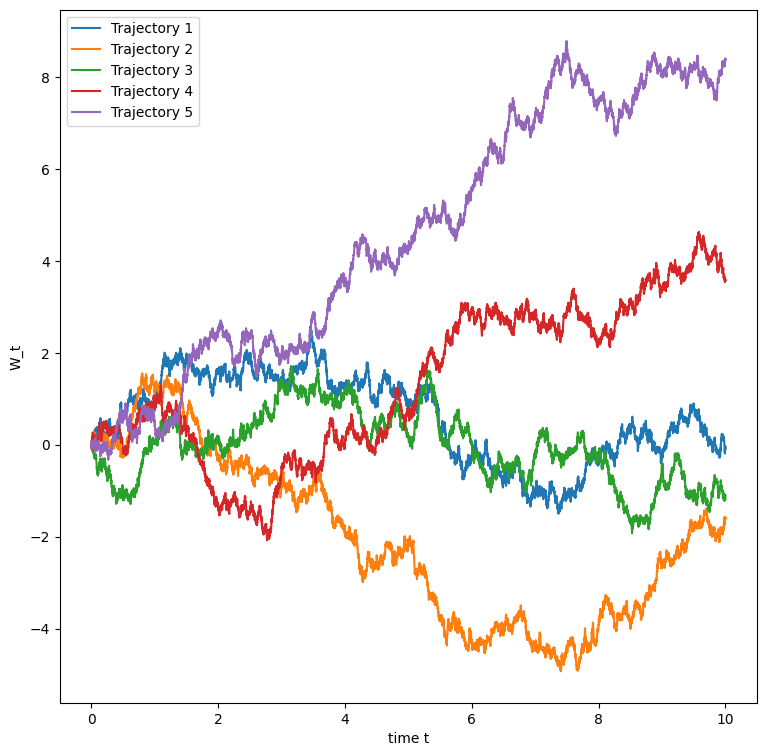

In [4]:
def run_brownian_motion(n_traj: int = 5, n_grid_points: int = 10000, t_start: float = 0.0, t_end: float = 10.0):
    time_grid = np.linspace(t_start, t_end, n_grid_points)
    grid_size = (t_end - t_start) / n_grid_points
    x_0 = np.array([n_traj*[0.0]])
    gaussian_noise = np.random.normal(size=(len(time_grid)-1, n_traj)) # (10000-1, 5)
    brownian_motion = np.sqrt(grid_size) * gaussian_noise.cumsum(axis=0)
    brownian_motion = np.concatenate([x_0, brownian_motion], axis=0)
    return time_grid, brownian_motion

fig,ax = plt.subplots(figsize=(9,9))
time,X_t = run_brownian_motion()
sample_labels = [f"Trajectory {i}" for i in range(1,6)]
ax.plot(time,X_t,label=sample_labels)
ax.set_xlabel("time t")
ax.set_ylabel("W_t")
ax.legend()

In [5]:
def run_sde(f_determ_drift: Callable,
            g_random_drift: Callable,
            x_start: np.array,
            t_start: float = 0.0,
            t_end: float = 1.0,
            n_steps: int = 10000,
            **kwargs
            ):
    """Function to run stochastic differential equation. We assume a deterministic initial distribution p_0."""
    
    n_traj, dim_x = x_start.shape

    time_grid = np.linspace(t_start, t_end, n_steps)
    step_size = time_grid[1] - time_grid[0]

    random_drift_grid = g_random_drift(time_grid)

    noise = np.random.normal(size=(n_steps, n_traj, dim_x))
    random_drift_grid_sample = np.sqrt(step_size) * random_drift_grid[:, None, None]*noise

    x_traj = [x_start]

    for idx, time in tqdm(enumerate(time_grid)):
        x = x_traj[idx]
        t = float(time_grid[idx])

        determ_drift = step_size * f_determ_drift(x, t)
        random_drift_sample = random_drift_grid_sample[idx]

        next_step = x + determ_drift + random_drift_sample

        x_traj.append(next_step)

    return np.stack(x_traj), time_grid

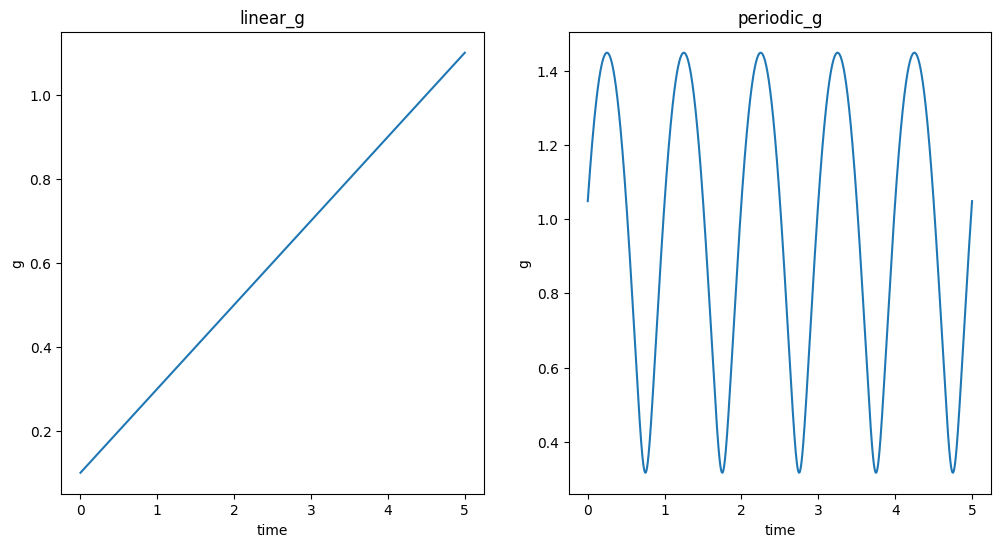

In [7]:
def linear_g(t, constant=0.2):
    """
    t - 1d np.ndarray or float
    returns : 1d np.ndarray or float
    """
    return 0.1 + constant * t

def periodic_g(t):
    """
    t - 1d np.ndarray or float
    returns : 1d np.ndarray or float
    """
    return np.sqrt(np.sin(2*np.pi*t)+1.10)

def plot_g_random_drift(drift_func_list: List[Callable], min_t: float = 0.0, max_t: float = 5.0,n_grid_points: int = 10000):
    """ Function to plot the random drift function  g."""
    fig, axs = plt.subplots(1,len(drift_func_list),figsize=(len(drift_func_list)*6,6))
    time = np.linspace(min_t,max_t,n_grid_points)

    for idx, drift_func in enumerate(drift_func_list):
        axs[idx].plot(time,drift_func(time))
        axs[idx].set_title(drift_func.__name__)
        axs[idx].set_xlabel("time")
        axs[idx].set_ylabel("g")

plot_g_random_drift([linear_g,periodic_g])

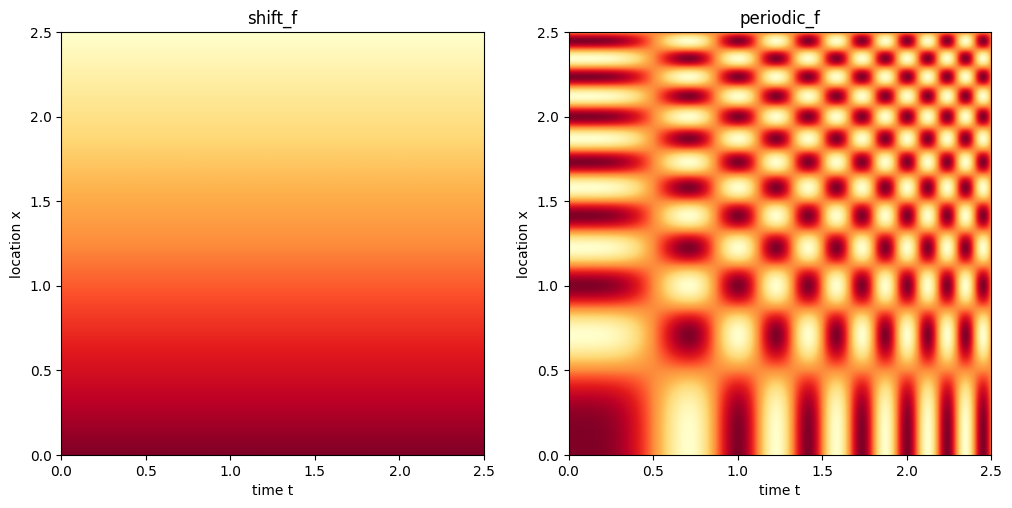

In [ ]:
def shift_f(x, t, shift=4.0):
    """
    x - shape(n, k) : a space coeffecients
    t - shape(n) or float : time coeffecients
    """
    return -(x-shift)

def periodic_f(x,t):
    """x - shape (n,k): space coefficients 
       t - shape (n) or float: time coefficients"""

    if isinstance(t,float):
        return 2*np.cos(2*np.pi*t**2)*(np.cos(2*np.pi*x)) #*normalizer[:,None])
    else:
        return 2*np.cos(2*np.pi*t**2)[:,None]*(np.cos(2*np.pi*x**2)) #*normalizer[:,None])

def plot_f_determ_drift(determ_func_list: List[Callable],
                min_t: float = 0.0, 
                max_t: float = 2.5, 
                min_x: float = 0.0,
                max_x: float = 2.5,
                n_grid_points: int = 1000,
                plot_contours=False):
    """Function to plot the function f(x,t) in an Ito-SDE."""
    time = np.linspace(min_t,max_t,n_grid_points)
    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x,t] for t,x in product(time,oned_grid)])
    extent = [min_x, max_x, min_t, max_t]
    
    fig,axs = plt.subplots(1,len(determ_func_list),figsize=(6*len(determ_func_list),6))
    
    for idx, determ_func in enumerate(determ_func_list):
        derivative = determ_func(twod_grid[:,0].reshape(-1,1),twod_grid[:,1])
        axs[idx].imshow(derivative.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent, cmap=plt.get_cmap('YlOrRd'))
        if plot_contours:
            axs[idx].contour(derivative.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent,color='black')
        axs[idx].set_title(determ_func.__name__)
        axs[idx].set_xlabel("time t")
        axs[idx].set_ylabel("location x")

plot_f_determ_drift([shift_f,periodic_f])

'''
Red/Yellow patches: Areas where f(x,t) has large positive values
Dark red/Brown patches: Areas where f(x,t) has large negative values
The intensity indicates the magnitude of the drift at that specific combination of location and time
'''

In [9]:
def animate_ito_sde(f_drift: Callable, g_drift: Callable, fpath_anim: str = None, n_steps: int = 100000, n_samples: int = 400,n_grid_points: int = 100, initial_dist:str ="normal", t_end=4.0):
    """Function to animate and plot a 1d SDE over time."""
    if initial_dist == "normal":
        x_start = np.random.normal(size=n_samples).reshape(-1,1)
    elif initial_dist == "uniform":
        x_start = np.random.uniform(size=n_samples).reshape(-1,1)
    else:
        raise ValueError
        
    x_traj,time_grid = run_sde(f_drift,g_drift,x_start=x_start,t_end=t_end,n_steps=n_steps)
    x_traj = x_traj.squeeze()
    
    fig, axs = plt.subplots(3,1,figsize=(24,36))
    camera = Camera(fig)
    
    oned_grid = np.linspace(x_traj.min(), x_traj.max(), len(time_grid))
    twod_grid = np.array([[x,t] for t,x in product(time_grid,oned_grid)])
    extent = [time_grid.min(), time_grid.max(),x_traj.min(), x_traj.max()]
    derivative = f_drift(twod_grid[:,0].reshape(-1,1),twod_grid[:,1])
    derivative_plot = derivative.reshape(len(time_grid),len(time_grid)).transpose()
    
    g_drift_per_time = g_drift(time_grid)

    for idx in tqdm(range(1,len(x_traj),max(int(len(x_traj)/200),1))):
    
        #Plot evolution over time over deterministic drift:
        axs[0].imshow(derivative_plot,interpolation='bilinear',origin='lower', extent = extent, cmap=plt.get_cmap('YlOrRd'),aspect='auto')
        if idx>5:
            for idy in range(10):
                axs[0].plot(time_grid[:idx],x_traj[:idx,idy].squeeze()) #,label=sample_labels)
            axs[0].plot(time_grid[:idx],x_traj[:idx].squeeze().mean(axis=1),color='black',linewidth=10)
        axs[0].set_title("Example trajectories (color=f)")

        #Plot distribution:
        sns.kdeplot(x_traj[idx],ax=axs[1])
        axs[1].set_title("Distribution of X_t")

        #Plot random drift:
        axs[2].plot(time_grid[:idx],g_drift_per_time[:idx])
        axs[2].set_title("Random drift g")
        camera.snap()
        
    animation = camera.animate() # animation ready
    plt.close()
    return animation

In [10]:
RUN_ANIMATION = False
N_STEPS = 1000
N_SAMPLES = 10000

In [15]:
fpath = f"simple_sde.mp4"
animation = animate_ito_sde(shift_f,periodic_g,n_steps=N_STEPS,n_samples=N_SAMPLES)
animation.save(fpath)
HTML(animation.to_html5_video())

0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [16]:
fpath = f"complex_sde.mp4"
animation = animate_ito_sde(periodic_f,linear_g,n_steps=N_STEPS,n_samples=N_SAMPLES)
animation.save(fpath)
HTML(animation.to_html5_video())
# HTML(f"""
# <video muted autoplay width="1280" height="960" controls>
#   <source src="complex_sde.mp4" type="video/mp4">
# </video>
# """)

0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Text(0.5, 1.0, 'Example trajectories')

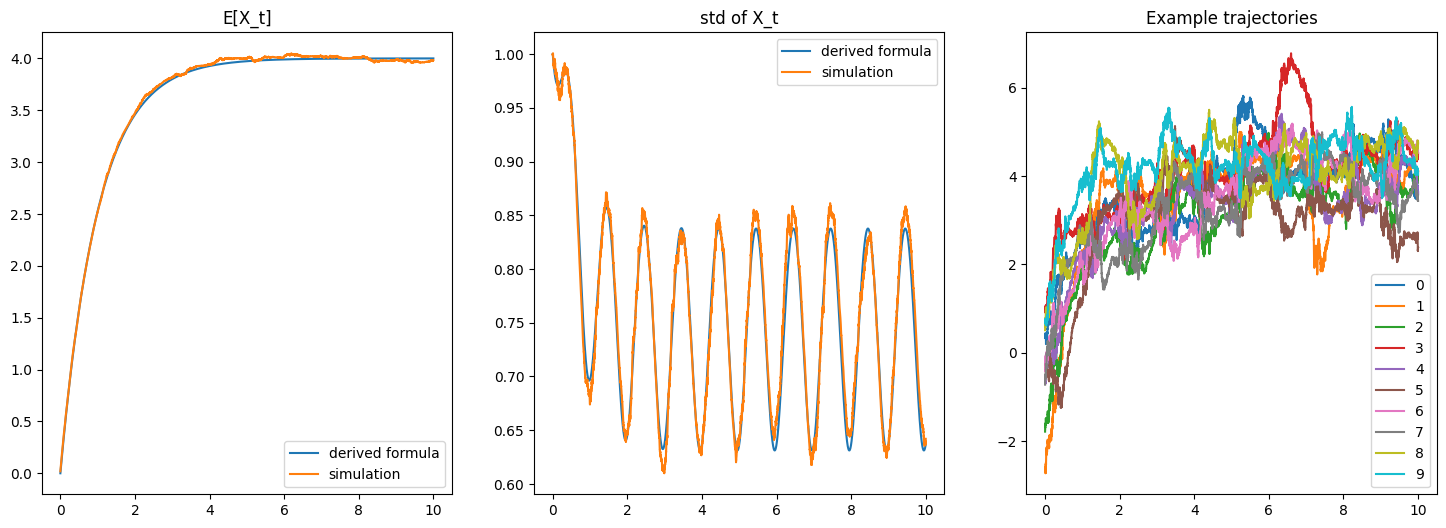

In [11]:
n_traj = 1000
import math

def ground_truth_mean(t):
    return 4*(1-np.exp(-t))

def ground_truth_std(t):
    summand_1 = 0.55
    summand_2 = np.exp(-2*t)*(0.45+0.5*math.pi/(1+math.pi**2))
    summand_3 = 0.5*(np.sin(2*math.pi*t)-math.pi*np.cos(2*math.pi*t))/(1+math.pi**2)
    return np.sqrt(summand_1 + summand_2 + summand_3)

x_init = np.random.normal(size=n_traj).reshape(-1, 1)
x_traj, time_grid = run_sde(shift_f, periodic_g, x_start=x_init, t_end=10.0)
mean_x_traj = x_traj.squeeze().mean(axis=1)[:-1]
std_x_traj = x_traj.squeeze().std(axis=1)[:-1]

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
ax1.plot(time_grid,ground_truth_mean(time_grid),label="derived formula")
ax1.plot(time_grid,mean_x_traj,label="simulation")
ax1.legend()
ax1.set_title("E[X_t]")

ax2.plot(time_grid,ground_truth_std(time_grid),label="derived formula")
ax2.plot(time_grid,std_x_traj,label="simulation")
ax2.legend()
ax2.set_title("std of X_t")

pd.DataFrame(x_traj[:-1,:10].squeeze(),index=time_grid).plot(ax=ax3)
ax3.set_title("Example trajectories")


0it [00:00, ?it/s]

Text(0.5, 1.0, 'Example trajectories')

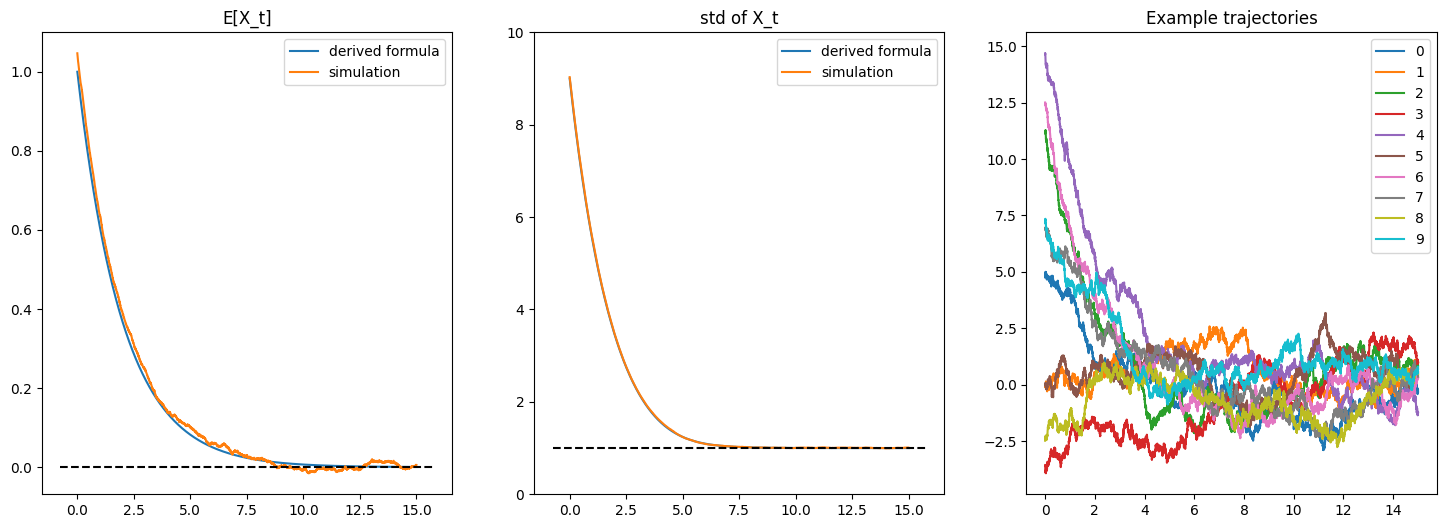

In [12]:
n_traj = 10000
INIT_MEAN = 1
INIT_STD = 9
INIT_VAR = INIT_STD ** 2
BETA_MIN = 0.0
BETA_MAX = 1.0
import math

def linear_beta(t): return BETA_MIN + (BETA_MAX - BETA_MIN) * t
def vp_g(t): return np.ones(shape=t.shape)*np.sqrt(BETA_MAX-BETA_MIN)
def vp_f(x, t):
    if isinstance(t, float): return -0.5*x*(BETA_MAX-BETA_MIN)
    else: return -0.5*(BETA_MAX-BETA_MIN)[:, None]*x

def ground_truth_mean(t): return INIT_MEAN*np.exp(-0.5*linear_beta(t))
def ground_truth_std(t): return np.sqrt(1+(INIT_VAR-1)*np.exp(-linear_beta(t)))

x_init = np.random.normal(loc=INIT_MEAN,scale=INIT_STD,size=n_traj).reshape(-1,1)
x_traj, time_grid = run_sde(vp_f, vp_g, x_start=x_init, t_start=0, t_end=15.0)
mean_x_traj = x_traj.squeeze().mean(axis=1)[:-1]
std_x_traj = x_traj.squeeze().std(axis=1)[:-1]

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
ax1.plot(time_grid,ground_truth_mean(time_grid),label="derived formula")
ax1.plot(time_grid,mean_x_traj,label="simulation")
ax1.legend()
ax1.set_title("E[X_t]")
ax1.hlines(0,ax1.get_xlim()[0],ax1.get_xlim()[1],linestyle='--',color='black')
#ax1.set_ylim(-1,INIT_MEAN+1)

ax2.plot(time_grid,ground_truth_std(time_grid),label="derived formula")
ax2.plot(time_grid,std_x_traj,label="simulation")
ax2.legend()
ax2.set_title("std of X_t")
ax2.hlines(1,ax2.get_xlim()[0],ax2.get_xlim()[1],linestyle='--',color='black')
ax2.set_ylim(0,INIT_STD+1)

pd.DataFrame(x_traj[:-1,:10].squeeze(),index=time_grid).plot(ax=ax3)
ax3.set_title("Example trajectories")

0it [00:00, ?it/s]

Text(0.5, 1.0, 'Example trajectories')

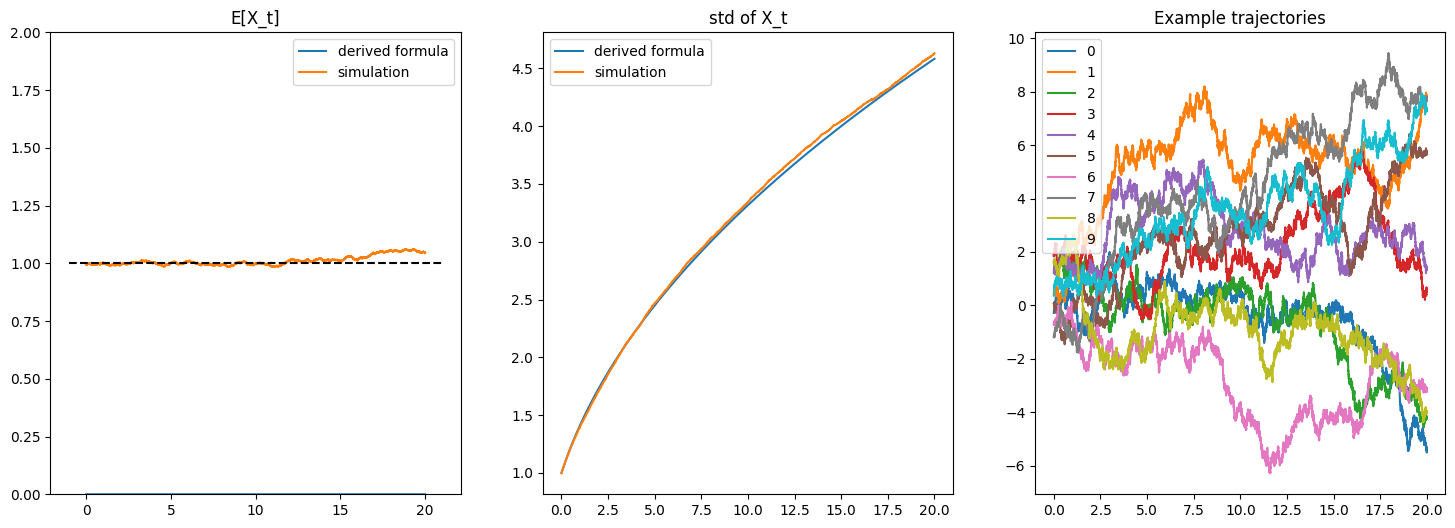

In [13]:
n_traj = 10000
INIT_MEAN = 1
INIT_STD = 1
INIT_VAR = INIT_STD**2
BETA_MIN = 0.0
BETA_MAX = 1.0
import math

def linear_beta(t): return BETA_MIN+(BETA_MAX-BETA_MIN)*t
def ve_g(t): return np.ones(shape=t.shape)*np.sqrt(BETA_MAX-BETA_MIN)
def ve_f(x,t): return 0*x
        

def ground_truth_mean(t): return INIT_MEAN*np.zeros(shape=t.shape)
def ground_truth_std(t): return np.sqrt(INIT_VAR+linear_beta(t))

x_init = np.random.normal(loc=INIT_MEAN,scale=INIT_STD,size=n_traj).reshape(-1,1)
x_traj, time_grid = run_sde(ve_f,ve_g,x_start=x_init,t_end=20.0,n_steps=10000)
mean_x_traj = x_traj.squeeze().mean(axis=1)[:-1]
std_x_traj = x_traj.squeeze().std(axis=1)[:-1]

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
ax1.plot(time_grid,ground_truth_mean(time_grid),label="derived formula")
ax1.plot(time_grid,mean_x_traj,label="simulation")
ax1.legend()
ax1.set_title("E[X_t]")
ax1.hlines(INIT_MEAN,ax1.get_xlim()[0],ax1.get_xlim()[1],linestyle='--',color='black')
ax1.set_ylim(INIT_MEAN-1,INIT_MEAN+1)

ax2.plot(time_grid,ground_truth_std(time_grid),label="derived formula")
ax2.plot(time_grid,std_x_traj,label="simulation")
ax2.legend()
ax2.set_title("std of X_t")

pd.DataFrame(x_traj[:-1,:10].squeeze(),index=time_grid).plot(ax=ax3)
ax3.set_title("Example trajectories")
